In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
import warnings as wn
from xhistogram.xarray import histogram as xh
%reload_ext autoreload
%autoreload 2
import esm2m.myfunctions as func
from xhistogram.xarray import histogram as xh

In [2]:
wn.filterwarnings('ignore')
cod = pd.read_csv('species/atlantic_cod.csv', header=0)
bass = pd.read_csv('species/stripped_bass.csv', header=0)
flounder = pd.read_csv('species/summer_flounder.csv', header=0)
seabream = pd.read_csv('species/seabream.csv', header=0)
red_drum = pd.read_csv('species/red_drum.csv', header=0)
n_lampfish = pd.read_csv('species/northern_lampfish.csv', header=0)
blue_lampfish = pd.read_csv('species/blue_lampfish.csv', header=0)
cunner = pd.read_csv('species/cunner.csv', header=0)
eelpout = pd.read_csv('species/eelpout.csv', header=0)

In [3]:
rootdir = '/local/ss23/GFDL_LEs/'
experiment = 'OCN/METABOLIC_INDEX/RCP85'
filename = 'MI_hitemp_sens_k01_ens*_1x1_1950_2100.nc'
path = rootdir+experiment+'/'+filename
all85 = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
avg85 = all85.sel(ensemble=30)
avg85 = avg85/2
all85 = all85.sel(ensemble=slice(0,30))
all85 = all85/2

In [4]:
rootdir = '/local/ss23/GFDL_LEs/'
experiment = 'OCN/METABOLIC_INDEX/RCP26'
filename = 'MI_hitemp_sens_k01_ens*_1x1_2006_2100.nc'
path = rootdir+experiment+'/'+filename
all26 = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
avg26 = all26.sel(ensemble=30)
avg26 = avg26/2
all26 = all26.sel(ensemble=slice(0,30))
all26 = all26/2

In [5]:
rootdir = '/local/ss23/GFDL_LEs/'
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':avg85['xt_ocean'],'yt_ocean':avg85['yt_ocean']})
oceanmask = np.isfinite(avg85['MI'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
ds_total = ~np.isnan(area.where(oceanmask))
total = ds_total.sum(dim='yt_ocean').sum(dim='xt_ocean')

In [6]:
def species(df_species):
    ds_cod = df_species.to_xarray()
    lon_bins = np.arange(-180,181)
    lat_bins = np.arange(-90,91)
    species_dist = xh(ds_cod['decimalLatitude'], ds_cod['decimalLongitude'],bins=[lat_bins, lon_bins])
    ds_hab = species_dist.where(species_dist<=1,1).rename({'decimalLongitude_bin':'xt_ocean','decimalLatitude_bin':'yt_ocean'})
    return ds_hab

In [7]:
def mi_dist(ds, mi, hab, area):
    hab = hab.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI'})
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redWhere = ~np.isnan(thresh_red.where(thresh_red['MI']!=0))
    redYear = redWhere.groupby('time.year').mean().sel(year=slice(1990,2100))
    redNum = (redYear*area).sum(['xt_ocean','yt_ocean'])
    redPerc = (redNum['MI']/total_hab['MI'])*100
    # redEns = redPerc.mean(dim='ensemble')
    return redPerc

# Atlantic Cod Distribution Uncertainty

In [21]:
cod_hab = species(cod)
cod_85 = mi_dist(all85, 2.0, cod_hab, area_masked)
cod_26 = mi_dist(all26, 2.0, cod_hab, area_masked)

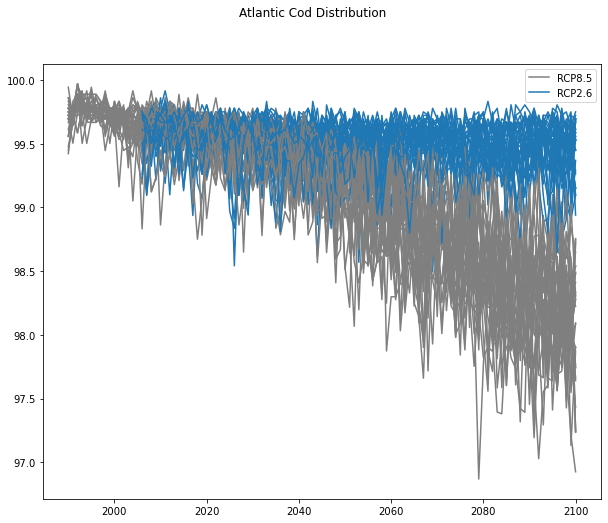

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Atlantic Cod Distribution')
wn.filterwarnings('ignore')
ax.plot(np.unique(cod_85.sel(ensemble=0)['year']),cod_85.sel(ensemble=ens),color='tab:gray',label='RCP8.5')
ax.plot(np.unique(cod_26.sel(ensemble=0)['year']),cod_26.sel(ensemble=ens),color='tab:blue',label='RCP2.6')
for ens in range(30):
    ax.plot(np.unique(cod_85.sel(ensemble=ens)['year']),cod_85.sel(ensemble=ens),color='tab:gray')
    ax.plot(np.unique(cod_26.sel(ensemble=ens)['year']),cod_26.sel(ensemble=ens),color='tab:blue')
ax.legend()

# Striped Bass Distribution Uncertainty

In [25]:
hab = species(bass)
hab_85 = mi_dist(all85, 5.0, hab, area_masked)
hab_26 = mi_dist(all26, 5.0, hab, area_masked)

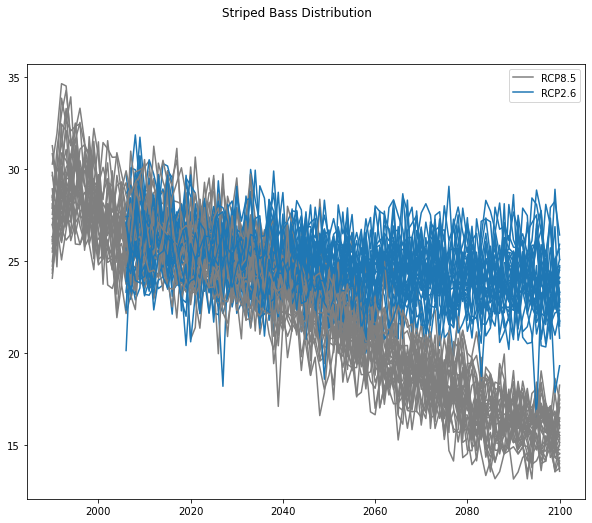

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Striped Bass Distribution')
wn.filterwarnings('ignore')
ax.plot(np.unique(hab_85.sel(ensemble=29)['year']),hab_85.sel(ensemble=ens),color='tab:gray',label='RCP8.5')
ax.plot(np.unique(hab_26.sel(ensemble=29)['year']),hab_26.sel(ensemble=ens),color='tab:blue',label='RCP2.6')
for ens in range(29):
    ax.plot(np.unique(hab_85.sel(ensemble=ens)['year']),hab_85.sel(ensemble=ens),color='tab:gray')
    ax.plot(np.unique(hab_26.sel(ensemble=ens)['year']),hab_26.sel(ensemble=ens),color='tab:blue')
ax.legend()

# Monthly

In [ ]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [-80.5,45.5,30.5,80.5]
fig.suptitle('RCP8.5 Ensemble Average Atlantic Cod Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')

In [42]:
def months_of_year(data,year,title,coords):
    fig, axs = plt.subplots(figsize=(20,16),nrows=4,ncols=3, subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title,fontsize=15) # Specify a figure title
    func.graph(data.sel(time=slice(year+'-01-01',year+'-01-31')), axs[0,0], 'Jan.', None, coords, True)
    axs[0,0].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-02-01',year+'-02-28')), axs[0,1], 'Feb.', None, coords, True)
    axs[0,1].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-03-01',year+'-03-31')), axs[0,2], 'March', None, coords, True)
    axs[0,2].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-04-01',year+'-04-30')), axs[1,0], 'April', None, coords, True)
    axs[1,0].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-05-01',year+'-05-31')), axs[1,1], 'May.', None, coords, True)
    axs[1,1].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-06-01',year+'-06-30')), axs[1,2], 'June.', None, coords, True)
    axs[1,2].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-07-01',year+'-07-31')), axs[2,0], 'July', None, coords, True)
    axs[2,0].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-08-01',year+'-08-31')), axs[2,1], 'August', None, coords, True)
    axs[2,1].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-09-01',year+'-09-30')), axs[2,2], 'Sept.', None, coords, True)
    axs[2,2].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-10-01',year+'-10-31')), axs[3,0], 'Oct.', None, coords, True)
    axs[3,0].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    func.graph(data.sel(time=slice(year+'-11-01',year+'-11-30')), axs[3,1], 'Nov.', None, coords, True)
    axs[3,1].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    im = func.graph(data.sel(time=slice(year+'-12-01',year+'-12-31')), axs[3,2], 'Dec.', None, coords, True)
    axs[3,2].scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
    cbar = plt.colorbar(im,ax=axs,orientation='horizontal',fraction=0.05,pad=0.05,shrink=0.5)
    cbar.set_label('metabolic index',fontsize=12)

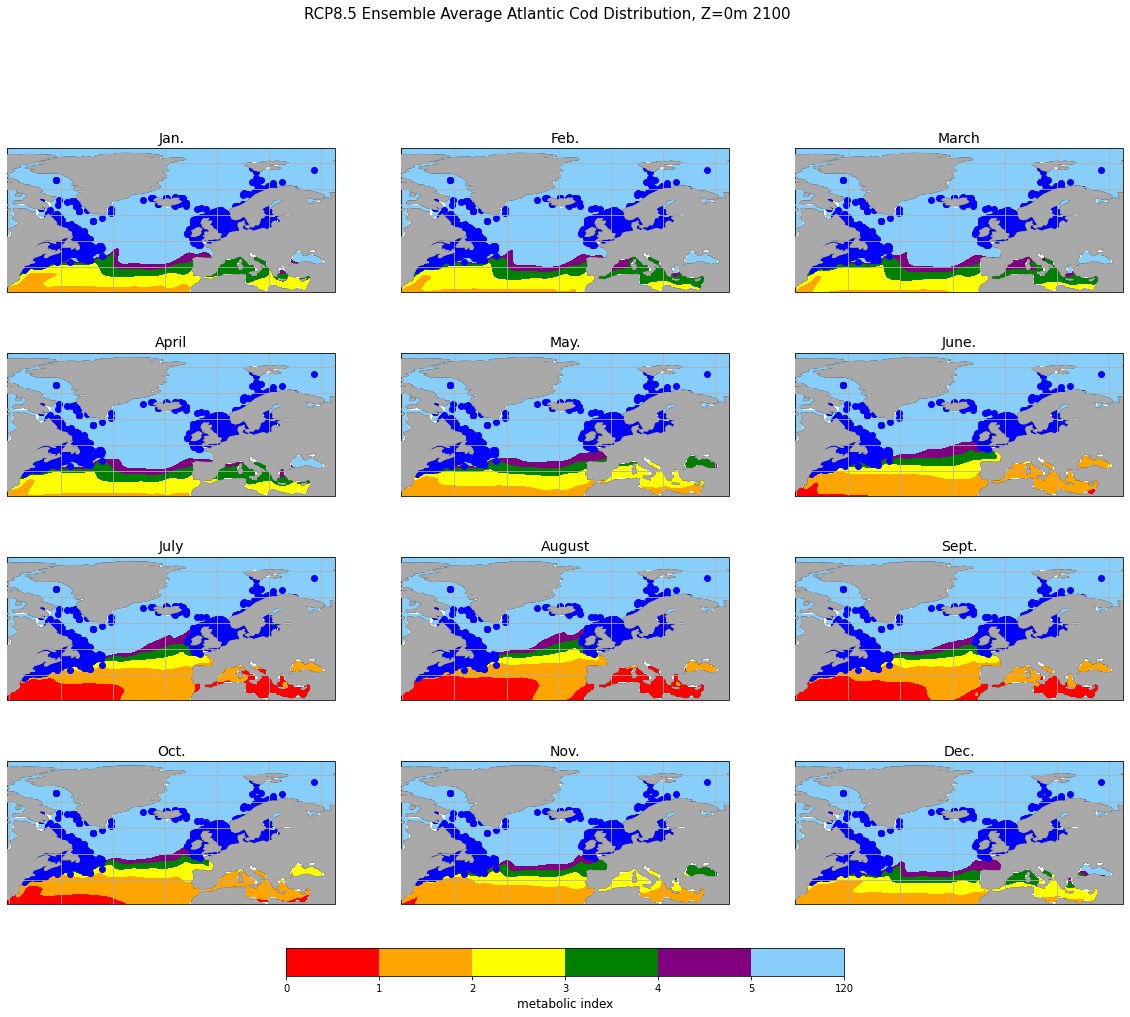

In [43]:
coords = [-80.5,45.5,30.5,80.5]
months_of_year(avg85,'2100','RCP8.5 Ensemble Average Atlantic Cod Distribution, Z=0m 2100', coords)

In [109]:
def ds_month(ds, mi, hab, area):
    hab = hab.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI'})
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = hab.reindex_like(red, method='nearest', tolerance=0.01)
    thresh_red = hab*red
    # redWhere = ~np.isnan(thresh_red.where(thresh_red['MI']!=0))
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
    redEns = redMonth.mean(dim='ensemble')
    return redMonth

In [39]:
def get_species(species):
    ds_cod = species.to_xarray()
    lon_bins = np.arange(-180,181)
    lat_bins = np.arange(-90,91)
    species_dist = xh(ds_cod['decimalLatitude'], ds_cod['decimalLongitude'],bins=[lat_bins, lon_bins])
    ds_hab = species_dist.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI','decimalLatitude_bin':'yt_ocean','decimalLongitude_bin':'xt_ocean'})
    ds_hab = ~np.isnan(ds_hab.where(ds_hab['MI']>0.5))
    return ds_hab

In [78]:
def month(ds, mi, ds_hab, area, num):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = ds_hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
    byMonth = ~np.isnan(redMonth.where(redMonth['MI']>=num))
    redNum = (byMonth*area).sum(['xt_ocean','yt_ocean'])
    # redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/total_hab['MI'])*100
    return percent

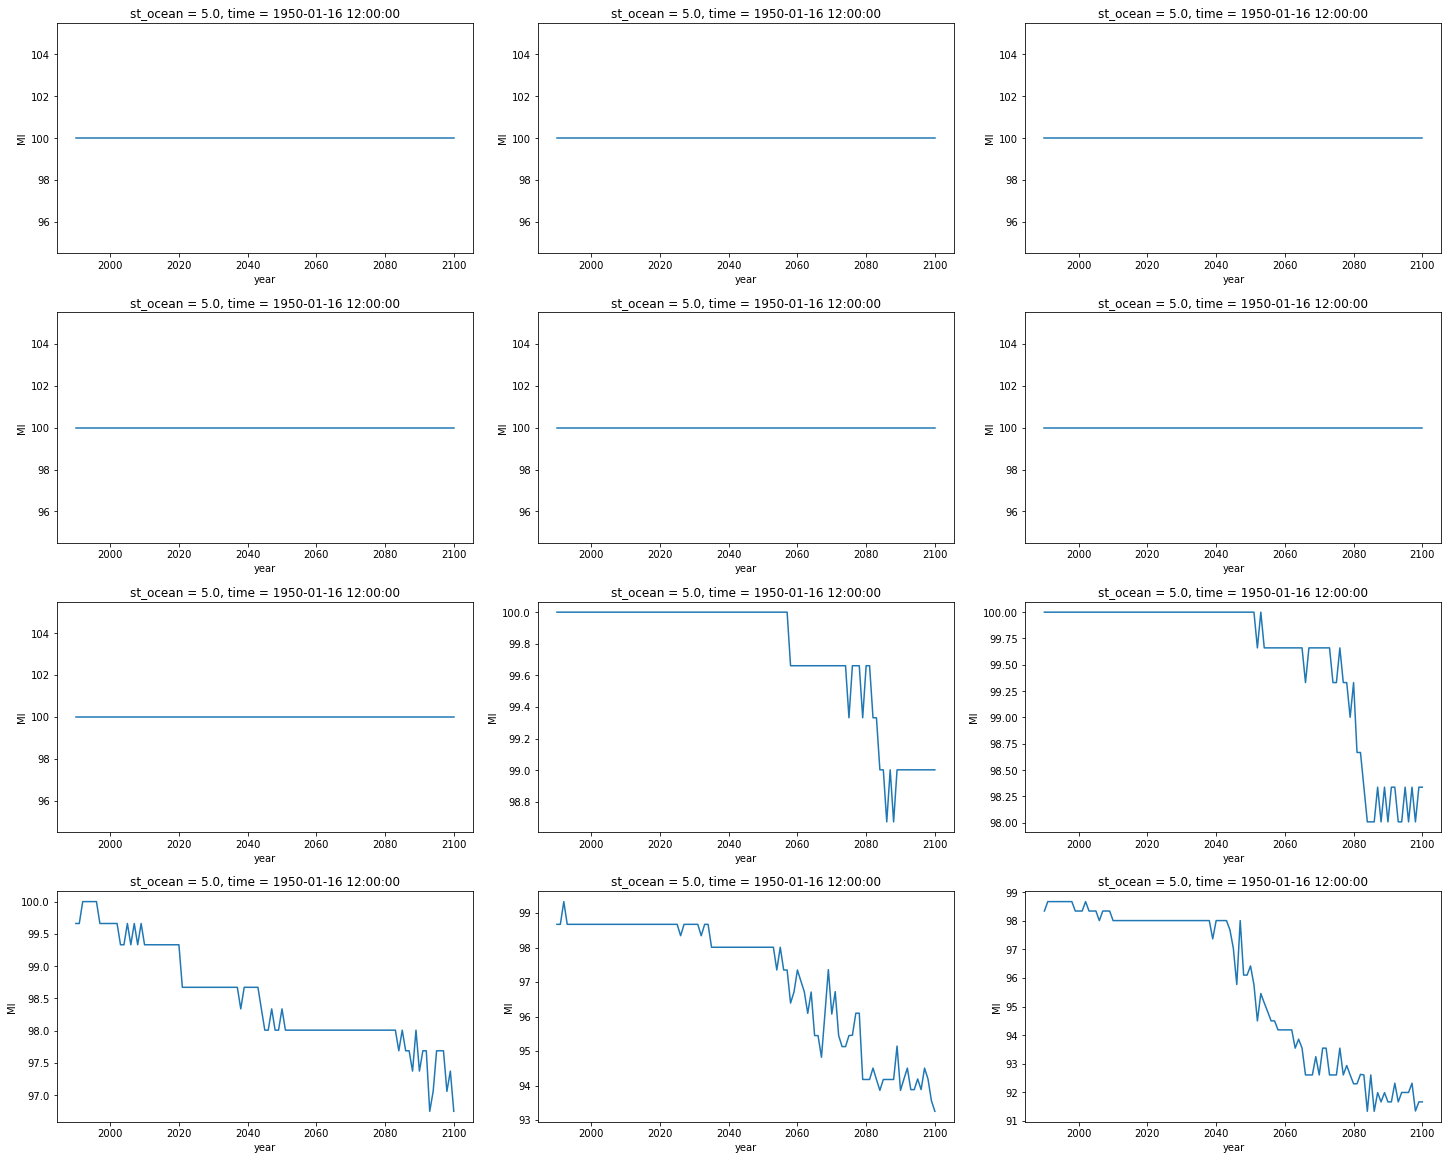

In [84]:
fig, axs = plt.subplots(figsize=(20,16),nrows=4,ncols=3, constrained_layout=True)
perc = month(avg85, 2.0, cod_hab, area_masked, 1)
perc.plot(ax=axs[0,0])
perc = month(avg85, 2.0, cod_hab, area_masked, 2)
perc.plot(ax=axs[0,1])
perc = month(avg85, 2.0, cod_hab, area_masked, 3)
perc.plot(ax=axs[0,2])
perc = month(avg85, 2.0, cod_hab, area_masked, 4)
perc.plot(ax=axs[1,0])
perc = month(avg85, 2.0, cod_hab, area_masked, 5)
perc.plot(ax=axs[1,1])
perc = month(avg85, 2.0, cod_hab, area_masked, 6)
perc.plot(ax=axs[1,2])
perc = month(avg85, 2.0, cod_hab, area_masked, 7)
perc.plot(ax=axs[2,0])
perc = month(avg85, 2.0, cod_hab, area_masked, 8)
perc.plot(ax=axs[2,1])
perc = month(avg85, 2.0, cod_hab, area_masked, 9)
perc.plot(ax=axs[2,2])
perc = month(avg85, 2.0, cod_hab, area_masked, 10)
perc.plot(ax=axs[3,0])
perc = month(avg85, 2.0, cod_hab, area_masked, 11)
perc.plot(ax=axs[3,1])
perc = month(avg85, 2.0, cod_hab, area_masked, 12)
perc.plot(ax=axs[3,2])

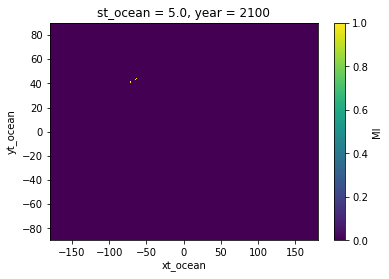

In [70]:
cod_1.sel(year=2100)['MI'].plot()

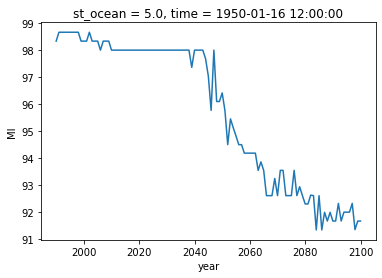

In [81]:
cod_12.plot()

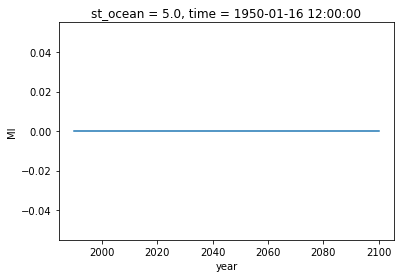

In [74]:
cod_12.plot()

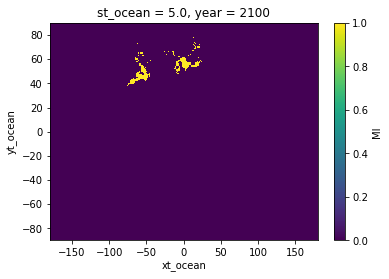

In [152]:
byMonth.sel(year=2100)['MI'].plot()

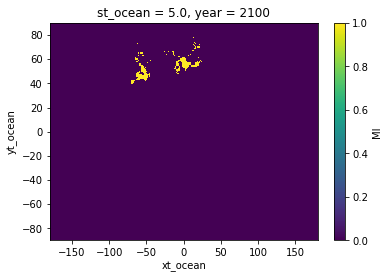

In [154]:
byMonth.sel(year=2100)['MI'].plot()

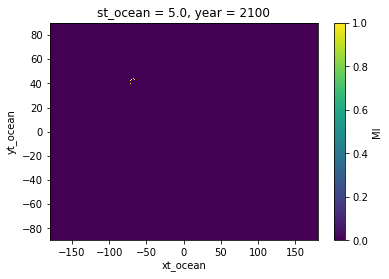

In [162]:
byMonth.sel(year=2100)['MI'].plot()

In [35]:
redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
byMonth = ~np.isnan(redMonth.where(redMonth['MI']==12))
redNum = (byMonth*area_masked).sum(['xt_ocean','yt_ocean'])
redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
percent = (redNum['MI']/redDen['MI'])*100

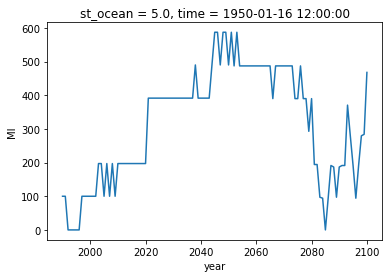

In [36]:
percent.plot()

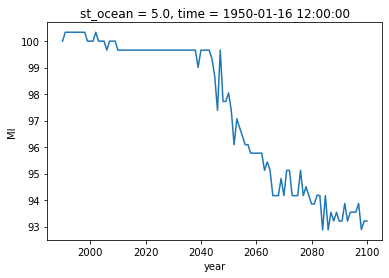

In [21]:
percent.plot()

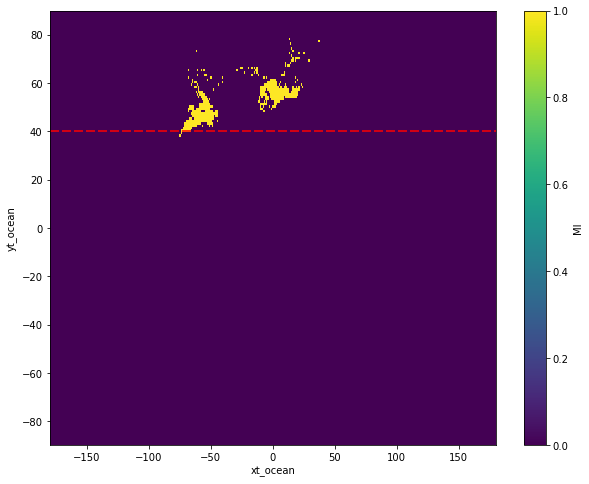

In [147]:
fig, ax = plt.subplots(figsize=(10,8))
ds_hab['MI'].plot(ax=ax)
ax.axhline(y=40.0, xmin=0,xmax=1,color='red',dashes=[6,2])

In [149]:
byMonth

,Array,Chunk
Bytes,7.19 MB,64.80 kB
Shape,"(111, 180, 360)","(1, 180, 360)"
Count,1554 Tasks,111 Chunks
Type,bool,numpy.ndarray


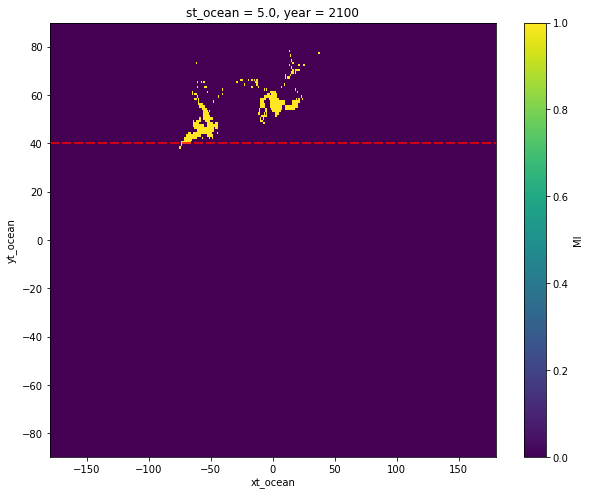

In [148]:
fig, ax = plt.subplots(figsize=(10,8))
byMonth['MI'].sel(year=2100).plot(ax=ax)
ax.axhline(y=40.0, xmin=0,xmax=1,color='red',dashes=[6,2])

In [110]:
red85 = ds_month(all85, 1.0, cod_hab, area_masked)
or85 = ds_month(all85, 2.0, cod_hab, area_masked)
yel85 = ds_month(all85, 3.0, cod_hab, area_masked)
gr85 = ds_month(all85, 4.0, cod_hab, area_masked)

In [51]:
red26 = ds_month(all26, 1.0, cod_hab, area_masked)
or26 = ds_month(all26, 2.0, cod_hab, area_masked)
yel26 = ds_month(all26, 3.0, cod_hab, area_masked)
gr26 = ds_month(all26, 4.0, cod_hab, area_masked)

In [98]:
def percent_month(ds, month, den):
    byMonth = ~np.isnan(ds.where(ds['MI']>=month))
    monthDen = ~np.isnan(den.where(den['MI']>=month))
    redNum = (byMonth*area_masked).sum(['xt_ocean','yt_ocean'])
    redDen = (monthDen.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/redDen['MI'])*100
    return percent

In [99]:
or1_85 = percent_month(or85, 1, or85)
or3_85 = percent_month(or85, 3, or85)
or6_85 = percent_month(or85, 6, or85)
or9_85 = percent_month(or85, 9, or85)
or12_85 = percent_month(or85, 12, or85)

In [58]:
or1_26 = percent_month(or26, 1, or85)
or3_26 = percent_month(or26, 3, or85)
or6_26 = percent_month(or26, 6, or85)
or9_26 = percent_month(or26, 9, or85)
or12_26 = percent_month(or26, 12, or85)

Text(0, 0.5, 'Percent of 1990 habitat')

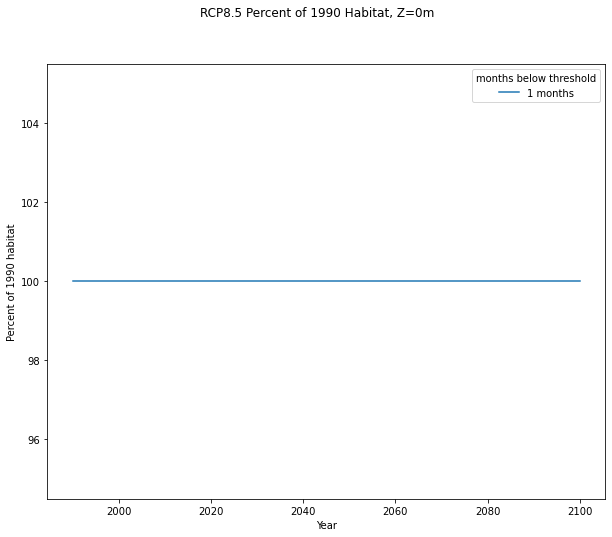

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Percent of 1990 Habitat, Z=0m')
ax.plot(np.unique(or1_85['year']),or1_85,color='tab:blue',label='1 month')
# ax.plot(np.unique(or3_85['year']),or3_85,color='tab:purple',label='3 months')
# ax.plot(np.unique(or6_85['year']),or6_85,color='tab:green',label='6 months')
# ax.plot(np.unique(or9_85['year']),or9_85,color='tab:olive',label='9 months')
# ax.plot(np.unique(or12_85['year']),or12_85,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')

# Atlantic Cod

In [79]:
cod_hab = get_species(cod)
cod_1 = month(avg85, 2.0, cod_hab, area_masked, 1)
cod_3 = month(avg85, 2.0, cod_hab, area_masked, 3)
cod_6 = month(avg85, 2.0, cod_hab, area_masked, 6)
cod_9 = month(avg85, 2.0, cod_hab, area_masked, 9)
cod_12 = month(avg85, 2.0, cod_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

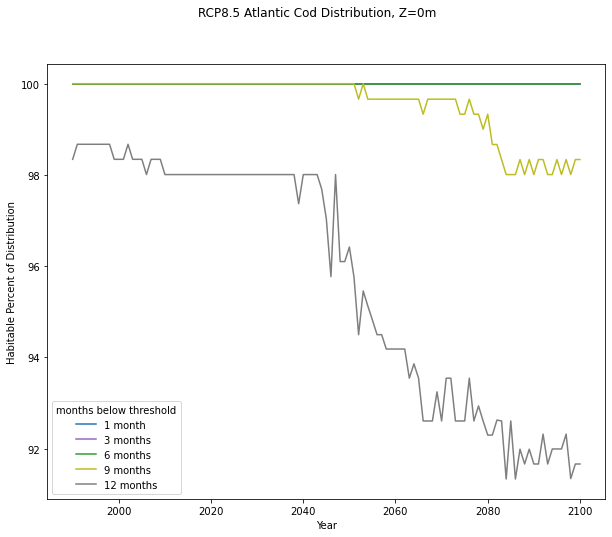

In [85]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Atlantic Cod Distribution, Z=0m')
ax.plot(np.unique(cod_1['year']),cod_1,color='tab:blue',label='1 month')
ax.plot(np.unique(cod_3['year']),cod_3,color='tab:purple',label='3 months')
ax.plot(np.unique(cod_6['year']),cod_6,color='tab:green',label='6 months')
ax.plot(np.unique(cod_9['year']),cod_9,color='tab:olive',label='9 months')
ax.plot(np.unique(cod_12['year']),cod_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Striped Bass

In [92]:
bass_hab = get_species(bass)
bass_1 = month(avg85, 5.0, bass_hab, area_masked, 1)
bass_3 = month(avg85, 5.0, bass_hab, area_masked, 3)
bass_6 = month(avg85, 5.0, bass_hab, area_masked, 6)
bass_9 = month(avg85, 5.0, bass_hab, area_masked, 9)
bass_12 = month(avg85, 5.0, bass_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

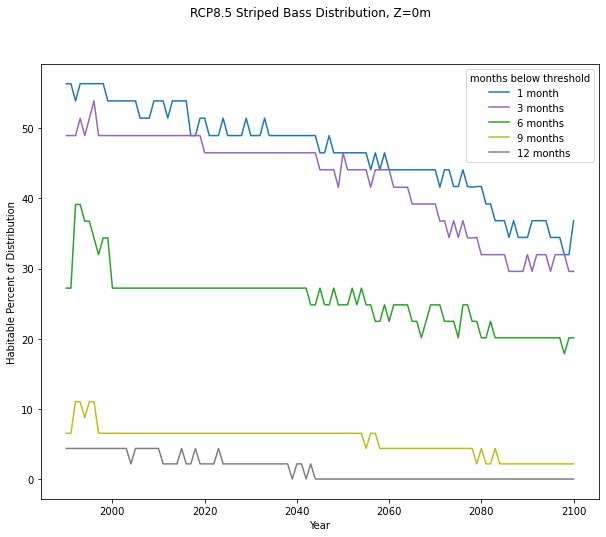

In [93]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Striped Bass Distribution, Z=0m')
ax.plot(np.unique(bass_1['year']),bass_1,color='tab:blue',label='1 month')
ax.plot(np.unique(bass_3['year']),bass_3,color='tab:purple',label='3 months')
ax.plot(np.unique(bass_6['year']),bass_6,color='tab:green',label='6 months')
ax.plot(np.unique(bass_9['year']),bass_9,color='tab:olive',label='9 months')
ax.plot(np.unique(bass_12['year']),bass_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Summer Flounder

In [94]:
flounder_hab = get_species(flounder)
flounder_1 = month(avg85, 3.0, flounder_hab, area_masked, 1)
flounder_3 = month(avg85, 3.0, flounder_hab, area_masked, 3)
flounder_6 = month(avg85, 3.0, flounder_hab, area_masked, 6)
flounder_9 = month(avg85, 3.0, flounder_hab, area_masked, 9)
flounder_12 = month(avg85, 3.0, flounder_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

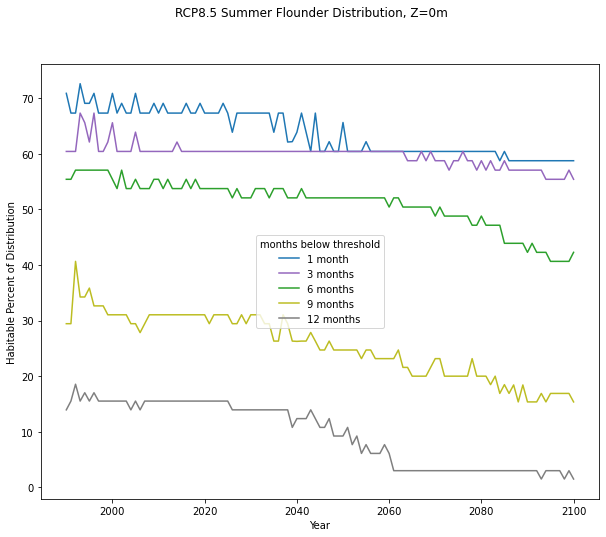

In [95]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Summer Flounder Distribution, Z=0m')
ax.plot(np.unique(flounder_1['year']),flounder_1,color='tab:blue',label='1 month')
ax.plot(np.unique(flounder_3['year']),flounder_3,color='tab:purple',label='3 months')
ax.plot(np.unique(flounder_6['year']),flounder_6,color='tab:green',label='6 months')
ax.plot(np.unique(flounder_9['year']),flounder_9,color='tab:olive',label='9 months')
ax.plot(np.unique(flounder_12['year']),flounder_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Sharpsnout Seabream

In [96]:
seabream_hab = get_species(seabream)
seabream_1 = month(avg85, 4.0, seabream_hab, area_masked, 1)
seabream_3 = month(avg85, 4.0, seabream_hab, area_masked, 3)
seabream_6 = month(avg85, 4.0, seabream_hab, area_masked, 6)
seabream_9 = month(avg85, 4.0, seabream_hab, area_masked, 9)
seabream_12 = month(avg85, 4.0, seabream_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

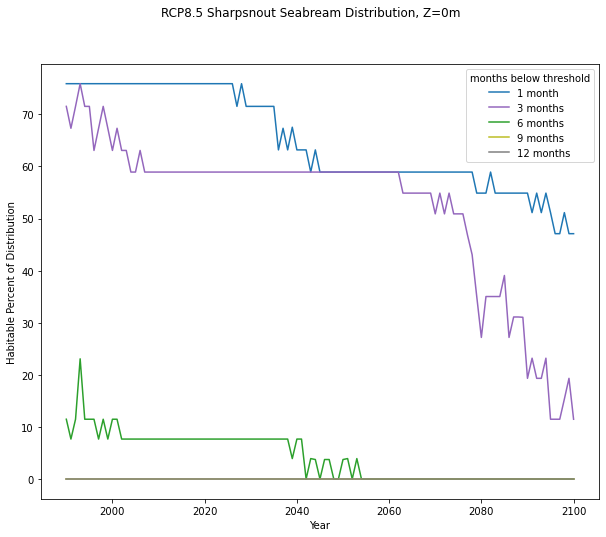

In [97]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Sharpsnout Seabream Distribution, Z=0m')
ax.plot(np.unique(seabream_1['year']),seabream_1,color='tab:blue',label='1 month')
ax.plot(np.unique(seabream_3['year']),seabream_3,color='tab:purple',label='3 months')
ax.plot(np.unique(seabream_6['year']),seabream_6,color='tab:green',label='6 months')
ax.plot(np.unique(seabream_9['year']),seabream_9,color='tab:olive',label='9 months')
ax.plot(np.unique(seabream_12['year']),seabream_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Red Drum

In [101]:
drum_hab = get_species(red_drum)
drum_1 = month(avg85, 5.0, drum_hab, area_masked, 1)
drum_3 = month(avg85, 5.0, drum_hab, area_masked, 3)
drum_6 = month(avg85, 5.0, drum_hab, area_masked, 6)
drum_9 = month(avg85, 5.0, drum_hab, area_masked, 9)
drum_12 = month(avg85, 5.0, drum_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

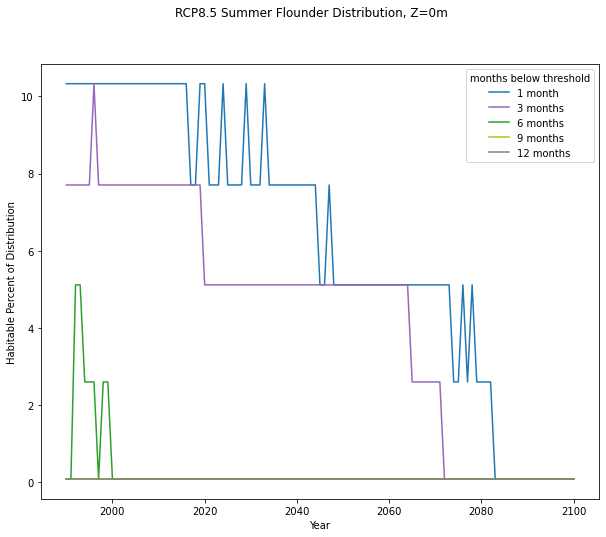

In [102]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Summer Flounder Distribution, Z=0m')
ax.plot(np.unique(drum_1['year']),drum_1,color='tab:blue',label='1 month')
ax.plot(np.unique(drum_3['year']),drum_3,color='tab:purple',label='3 months')
ax.plot(np.unique(drum_6['year']),drum_6,color='tab:green',label='6 months')
ax.plot(np.unique(drum_9['year']),drum_9,color='tab:olive',label='9 months')
ax.plot(np.unique(drum_12['year']),drum_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Northern Lampfish

In [103]:
lamp_hab = get_species(n_lampfish)
lamp_1 = month(avg85, 2.0, lamp_hab, area_masked, 1)
lamp_3 = month(avg85, 2.0, lamp_hab, area_masked, 3)
lamp_6 = month(avg85, 2.0, lamp_hab, area_masked, 6)
lamp_9 = month(avg85, 2.0, lamp_hab, area_masked, 9)
lamp_12 = month(avg85, 2.0, lamp_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

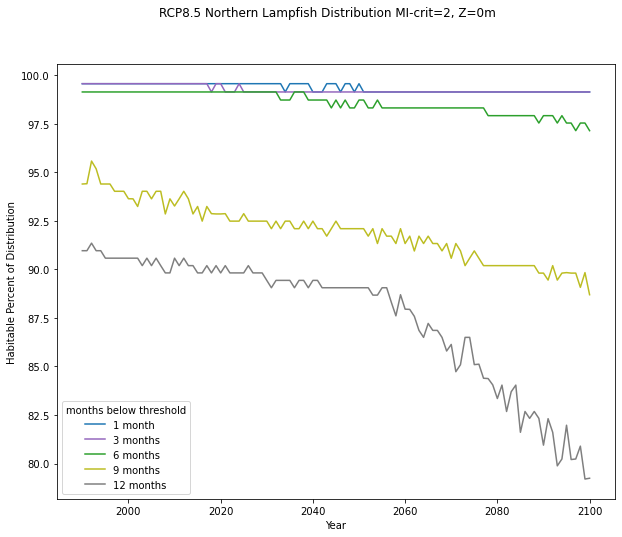

In [104]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Northern Lampfish Distribution MI-crit=2, Z=0m')
ax.plot(np.unique(lamp_1['year']),lamp_1,color='tab:blue',label='1 month')
ax.plot(np.unique(lamp_3['year']),lamp_3,color='tab:purple',label='3 months')
ax.plot(np.unique(lamp_6['year']),lamp_6,color='tab:green',label='6 months')
ax.plot(np.unique(lamp_9['year']),lamp_9,color='tab:olive',label='9 months')
ax.plot(np.unique(lamp_12['year']),lamp_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

In [105]:
lamp_hab = get_species(n_lampfish)
lamp_1 = month(avg85, 4.0, lamp_hab, area_masked, 1)
lamp_3 = month(avg85, 4.0, lamp_hab, area_masked, 3)
lamp_6 = month(avg85, 4.0, lamp_hab, area_masked, 6)
lamp_9 = month(avg85, 4.0, lamp_hab, area_masked, 9)
lamp_12 = month(avg85, 4.0, lamp_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

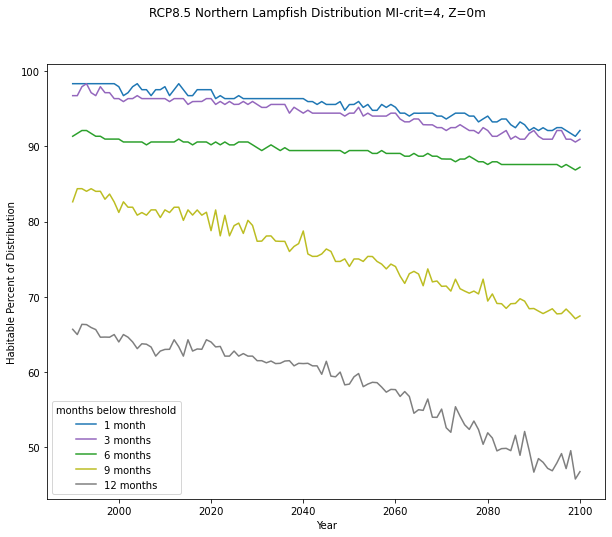

In [106]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Northern Lampfish Distribution MI-crit=4, Z=0m')
ax.plot(np.unique(lamp_1['year']),lamp_1,color='tab:blue',label='1 month')
ax.plot(np.unique(lamp_3['year']),lamp_3,color='tab:purple',label='3 months')
ax.plot(np.unique(lamp_6['year']),lamp_6,color='tab:green',label='6 months')
ax.plot(np.unique(lamp_9['year']),lamp_9,color='tab:olive',label='9 months')
ax.plot(np.unique(lamp_12['year']),lamp_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Blue Lampfish

In [107]:
lamp_hab = get_species(blue_lampfish)
lamp_1 = month(avg85, 3.0, lamp_hab, area_masked, 1)
lamp_3 = month(avg85, 3.0, lamp_hab, area_masked, 3)
lamp_6 = month(avg85, 3.0, lamp_hab, area_masked, 6)
lamp_9 = month(avg85, 3.0, lamp_hab, area_masked, 9)
lamp_12 = month(avg85, 3.0, lamp_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

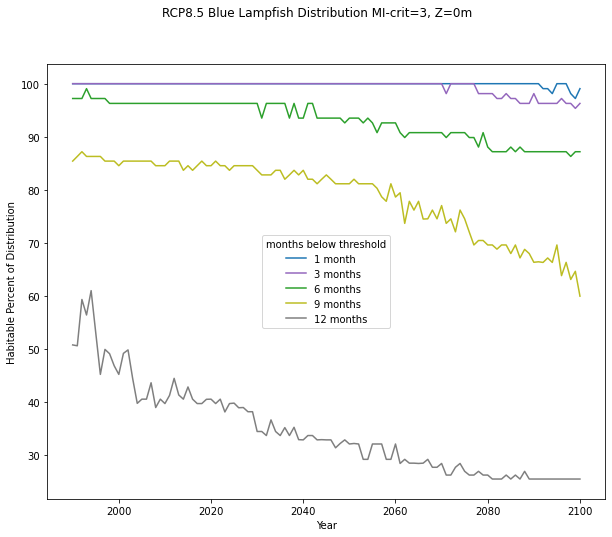

In [108]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Blue Lampfish Distribution MI-crit=3, Z=0m')
ax.plot(np.unique(lamp_1['year']),lamp_1,color='tab:blue',label='1 month')
ax.plot(np.unique(lamp_3['year']),lamp_3,color='tab:purple',label='3 months')
ax.plot(np.unique(lamp_6['year']),lamp_6,color='tab:green',label='6 months')
ax.plot(np.unique(lamp_9['year']),lamp_9,color='tab:olive',label='9 months')
ax.plot(np.unique(lamp_12['year']),lamp_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

In [109]:
lamp_hab = get_species(blue_lampfish)
lamp_1 = month(avg85, 5.0, lamp_hab, area_masked, 1)
lamp_3 = month(avg85, 5.0, lamp_hab, area_masked, 3)
lamp_6 = month(avg85, 5.0, lamp_hab, area_masked, 6)
lamp_9 = month(avg85, 5.0, lamp_hab, area_masked, 9)
lamp_12 = month(avg85, 5.0, lamp_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

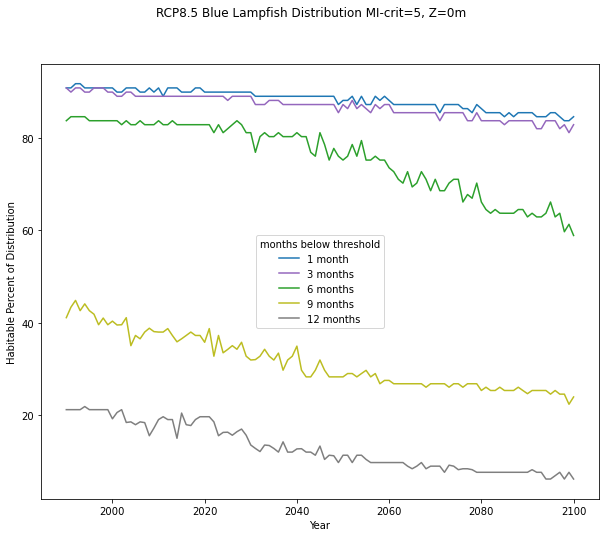

In [110]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Blue Lampfish Distribution MI-crit=5, Z=0m')
ax.plot(np.unique(lamp_1['year']),lamp_1,color='tab:blue',label='1 month')
ax.plot(np.unique(lamp_3['year']),lamp_3,color='tab:purple',label='3 months')
ax.plot(np.unique(lamp_6['year']),lamp_6,color='tab:green',label='6 months')
ax.plot(np.unique(lamp_9['year']),lamp_9,color='tab:olive',label='9 months')
ax.plot(np.unique(lamp_12['year']),lamp_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Cunner

In [111]:
cunner_hab = get_species(cunner)
cunner_1 = month(avg85, 2.0, cunner_hab, area_masked, 1)
cunner_3 = month(avg85, 2.0, cunner_hab, area_masked, 3)
cunner_6 = month(avg85, 2.0, cunner_hab, area_masked, 6)
cunner_9 = month(avg85, 2.0, cunner_hab, area_masked, 9)
cunner_12 = month(avg85, 2.0, cunner_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

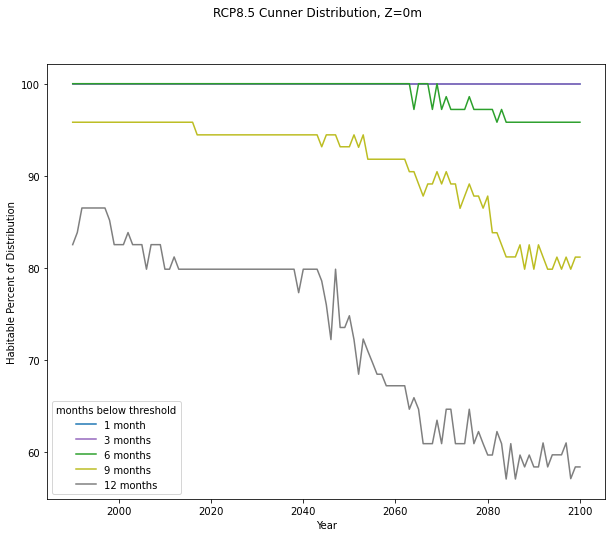

In [112]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Cunner Distribution, Z=0m')
ax.plot(np.unique(cunner_1['year']),cunner_1,color='tab:blue',label='1 month')
ax.plot(np.unique(cunner_3['year']),cunner_3,color='tab:purple',label='3 months')
ax.plot(np.unique(cunner_6['year']),cunner_6,color='tab:green',label='6 months')
ax.plot(np.unique(cunner_9['year']),cunner_9,color='tab:olive',label='9 months')
ax.plot(np.unique(cunner_12['year']),cunner_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Viviparous Eelpout

In [113]:
eel_hab = get_species(eelpout)
eel_1 = month(avg85, 4.0, eel_hab, area_masked, 1)
eel_3 = month(avg85, 4.0, eel_hab, area_masked, 3)
eel_6 = month(avg85, 4.0, eel_hab, area_masked, 6)
eel_9 = month(avg85, 4.0, eel_hab, area_masked, 9)
eel_12 = month(avg85, 4.0, eel_hab, area_masked, 12)

Text(0, 0.5, 'Habitable Percent of Distribution')

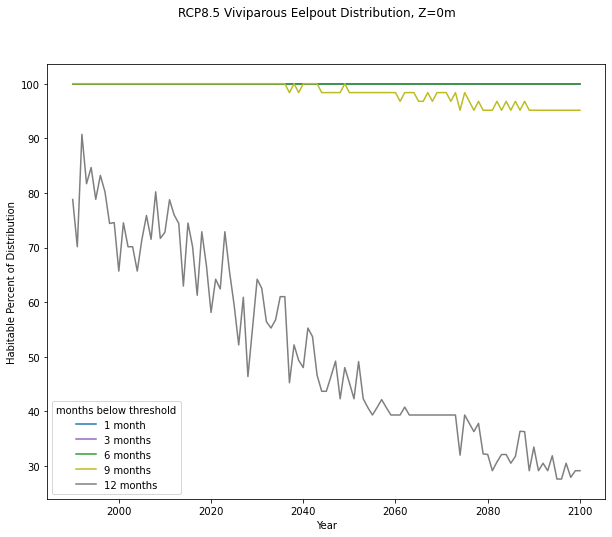

In [115]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Viviparous Eelpout Distribution, Z=0m')
ax.plot(np.unique(eel_1['year']),eel_1,color='tab:blue',label='1 month')
ax.plot(np.unique(eel_3['year']),eel_3,color='tab:purple',label='3 months')
ax.plot(np.unique(eel_6['year']),eel_6,color='tab:green',label='6 months')
ax.plot(np.unique(eel_9['year']),eel_9,color='tab:olive',label='9 months')
ax.plot(np.unique(eel_12['year']),eel_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')